In [1]:
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import re
import numpy as np
import pandas as pd

import SequenceDataORM as sqd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
engine = create_engine('sqlite:///NS001_evolved_mutations_copy2.db', echo=False) # our database connection
session = sessionmaker(bind=engine)() # the session object is how we make queries through sqlalchemy

# Ignoring ancestral polymorphisms, how many SNPs surpass a given frequency threshold for each sample?

In [3]:
ancestral_snps = [snp for snp in session.query(sqd.SNP_Mutation)
                  if ('Aggregate_NS001_Ancestors' in snp.samples) or
                     ('Ancestor_S1' in snp.samples) or
                     ('Ancestor_S2' in snp.samples) or
                     ('Ancestor_S3' in snp.samples)]

In [4]:
def new_snps_above_frequency(sample, freq_cutoff):
    snps_above_frequency = [snp for snp in
                            (session.query(sqd.SNP_Mutation).join(sqd.SNP_Evidence)
                             .filter(sqd.SNP_Evidence.sample==sample)
                             .filter(sqd.SNP_Evidence.frequency >= freq_cutoff))]
    new_snps_above_freq = [snp for snp in snps_above_frequency
                           if ('Aggregate_NS001_Ancestors' not in snp.samples) and
                              ('Ancestor_S1' not in snp.samples) and
                              ('Ancestor_S2' not in snp.samples) and
                              ('Ancestor_S3' not in snp.samples)]
    return new_snps_above_freq

In [5]:
evolvedt1_samples = [smpl for smpl in session.query(sqd.DNA_Sample).filter(sqd.DNA_Sample.name.like('%t1%'))]
evolvedt2_samples = [smpl for smpl in session.query(sqd.DNA_Sample).filter(sqd.DNA_Sample.name.like('%t2%'))]

In [6]:
def mu_and_counts(samples, cutoff):
    mus = []
    counts = []
    names = []
    for sample in samples:
        mu = (session.query(sqd.Strain, sqd.MutationCondition)
                     .filter(sqd.Strain.mutation_rate_condition==sqd.MutationCondition.name)
                     .filter(sqd.Strain.name==sample.strain)
                     .first())[1].mu_est
        count = len(new_snps_above_frequency(sample.name, cutoff))
        mus.append(mu)
        counts.append(count)
        names.append(sample.name)
    mu_c_df = pd.DataFrame(data={'name': names, 'mu': mus, 'count': counts})
    return mu_c_df
    
def plot_snps_by_condition(mu_c_df, axes, color='r'):
    for row in mu_c_df.itertuples():
        axes.plot(row.mu, row.count, '.', color=color, markersize=12);
    means = mu_c_df.groupby(by='mu').mean()
    for row in means.itertuples():
        axes.plot(row.Index, row.count, '*', color=color, markersize=20, markeredgecolor='k')
    axes.set_xscale('log')
    ax.set_xlabel('mutation rate (rif resistance)', fontsize=20);
    ax.set_ylabel('number of mutations', fontsize=20);

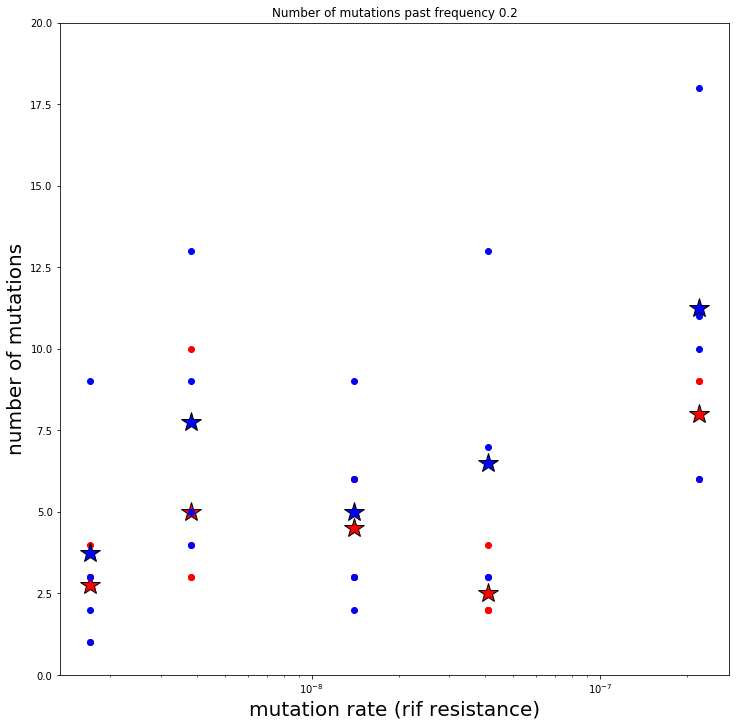

In [18]:
fig = plt.figure(figsize=(12,12));
ax = fig.add_subplot(111);
cutoff = .2
evolved_t1_df = mu_and_counts(evolvedt1_samples, cutoff)
evolved_t2_df = mu_and_counts(evolvedt2_samples, cutoff)
plot_snps_by_condition(evolved_t1_df, ax, 'r')
plot_snps_by_condition(evolved_t2_df, ax, 'b')
ax.set_title(f'Number of mutations past frequency {cutoff}');
ax.set_ylim(0,20);

# Comparing to immediate ancestor at time t1 instead of original ancestor

In [8]:
def new_snps_above_t1frequency(sample, freq_cutoff):
    if 't2' not in sample:
        raise ValueError('Need a sample from time t2')
    snps_above_frequency = [snp for snp in
                            (session.query(sqd.SNP_Mutation).join(sqd.SNP_Evidence)
                             .filter(sqd.SNP_Evidence.sample==sample)
                             .filter(sqd.SNP_Evidence.frequency >= freq_cutoff))]
    ancestor_sample_name = re.sub('t2', 't1', sample)
    new_snps_above_freq = [snp for snp in snps_above_frequency
                           if ('Aggregate_NS001_Ancestors' not in snp.samples) and
                              ('Ancestor_S1' not in snp.samples) and
                              ('Ancestor_S2' not in snp.samples) and
                              ('Ancestor_S3' not in snp.samples) and
                              (ancestor_sample_name not in snp.samples)]
    return new_snps_above_freq

def mu_and_counts_reft1(samples, cutoff):
    mus = []
    counts = []
    names = []
    for sample in samples:
        mu = (session.query(sqd.Strain, sqd.MutationCondition)
                     .filter(sqd.Strain.mutation_rate_condition==sqd.MutationCondition.name)
                     .filter(sqd.Strain.name==sample.strain)
                     .first())[1].mu_est
        count = len(new_snps_above_t1frequency(sample.name, cutoff))
        mus.append(mu)
        counts.append(count)
        names.append(sample.name)
    mu_c_df = pd.DataFrame(data={'name': names, 'mu': mus, 'count': counts})
    return mu_c_df

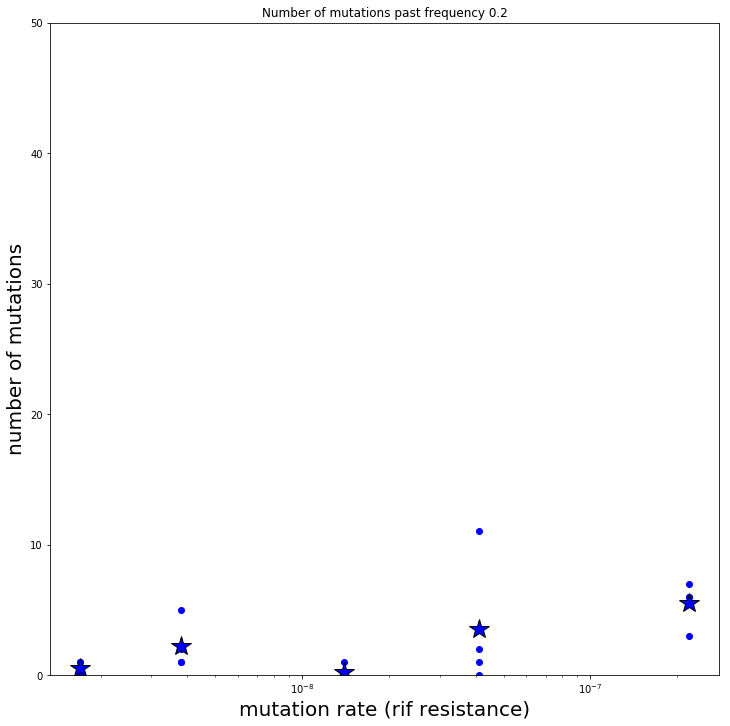

In [19]:
fig = plt.figure(figsize=(12,12));
ax = fig.add_subplot(111);
cutoff = .2
evolved_t2_df_c1 = mu_and_counts_reft1(evolvedt2_samples, cutoff)
plot_snps_by_condition(evolved_t2_df_c1, ax, 'b')
ax.set_title(f'Number of mutations past frequency {cutoff}');
ax.set_ylim(0,50);

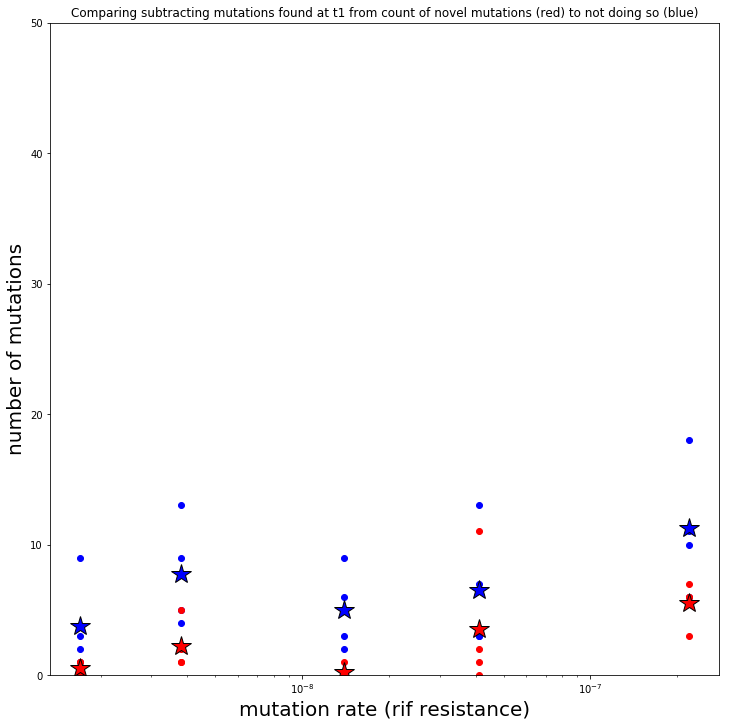

In [20]:
fig = plt.figure(figsize=(12,12));
ax = fig.add_subplot(111);
plot_snps_by_condition(evolved_t2_df, ax, 'b')
plot_snps_by_condition(evolved_t2_df_c1, ax, 'r')
ax.set_ylim(0,50);
ax.set_title('Comparing subtracting mutations found at t1 from count of novel mutations (red) to not doing so (blue)');